# モジュールのインポート

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO
%matplotlib inline

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score
from sklearn import grid_search

from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold

from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve

C:\Users\Tomori kengo\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Tomori kengo\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# データの読み込み

In [51]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [52]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [53]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# 前処理

In [54]:
# 各カラムの欠損値の確認
print(df_train.isnull().sum())
print(df_test.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [55]:
# Embarkedの欠損値補完
# 最頻値を確認
df_train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [56]:
# 最頻値のSで欠損値を補完
df_train['Embarked'] = df_train['Embarked'].fillna('S')

In [57]:
# Sの数が+2されているか確認
df_train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [58]:
# SibSp:spouses aboard the Titanic(タイタニックに乗船している配偶者)
# Parch:children aboard the Titanic(タイタニックに乗船している子供) 
# SibSp + Parch = Familyカラムを作成
df_train['Family'] = df_train['SibSp'] + df_train['Parch']
df_test['Family'] = df_test['SibSp'] + df_test['Parch']

In [59]:
# Ageの欠損値を中央値で補完
df_train['Age'] = df_train['Age'].fillna(df_train['Age'].median())
df_test['Age'] = df_test['Age'].fillna(df_test['Age'].median())

In [60]:
# Fareの欠損値を中央値で補完
df_test['Fare'] = df_test['Fare'].fillna(df_test['Fare'].median())

In [61]:
# Pclass×Sexのクロス集計でSurvivedの値の平均値を確認
df_train.pivot_table(index='Pclass', columns='Sex', values='Survived', aggfunc='mean')

Sex,female,male
Pclass,,
1,0.968085,0.368852
2,0.921053,0.157407
3,0.500000,0.135447


In [62]:
# 文字型データをダミー変換
# df_train['Sex'] = pd.get_dummies(df_train['Sex'])
df_train['Embarked'] = pd.get_dummies(df_train['Embarked'])
# df_test['Sex'] = pd.get_dummies(df_test['Sex'])
df_test['Embarked'] = pd.get_dummies(df_test['Embarked'])

In [63]:
# 処理が難しいカラムはいったん削除
df_train = df_train.drop(['Name', 'Ticket', 'Cabin'], axis=1)
df_test = df_test.drop(['Name', 'Ticket', 'Cabin'], axis=1)

In [64]:
# 上記処理で欠損値が消えたかどうか確認
print(df_train.isnull().sum())
print(df_train.isnull().sum())

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
Family         0
dtype: int64
PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
Family         0
dtype: int64


In [70]:
# Pclass×Sexの値を格納する新しいカラムの準備
# male=1, female=-1に変換
df_train['Sex'] = df_train['Sex'].replace('male', 1).replace('female', -1 )
df_test['Sex'] = df_test['Sex'].replace('male', 1).replace('female', -1 )

In [71]:
# 変換できているかどうか確認
df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family
0,1,0,3,1,22.0,1,0,7.2500,0,1
1,2,1,1,-1,38.0,1,0,71.2833,1,1
2,3,1,3,-1,26.0,0,0,7.9250,0,0
3,4,1,1,-1,35.0,1,0,53.1000,0,1
4,5,0,3,1,35.0,0,0,8.0500,0,0


In [74]:
# Pclass の値にSexの値を加えた新しいカラムPSを作成
# female=-1にすることでdf_train['Pclass'] + df_train['Sex']とすることで階級が高い女性ほど値が小さくなるようにする
df_train['PS'] = df_train['Pclass'] + df_train['Sex']
df_test['PS'] = df_test['Pclass'] + df_test['Sex']

In [73]:
# 作成カラムの確認
df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family,PS
0,1,0,3,1,22.0,1,0,7.2500,0,1,4
1,2,1,1,-1,38.0,1,0,71.2833,1,1,0
2,3,1,3,-1,26.0,0,0,7.9250,0,0,2
3,4,1,1,-1,35.0,1,0,53.1000,0,1,0
4,5,0,3,1,35.0,0,0,8.0500,0,0,4


In [75]:
df_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family,PS
0,892,3,1,34.5,0,0,7.8292,0,0,4
1,893,3,-1,47.0,1,0,7.0000,0,1,2
2,894,2,1,62.0,0,0,9.6875,0,0,3
3,895,3,1,27.0,0,0,8.6625,0,0,4
4,896,3,-1,22.0,1,1,12.2875,0,2,2


In [94]:
# ダミー変数がマイナスのままだと予測結果に影響する？ので0,1データにする
# replaceする元データが数値データのときはクォーテーション指定する必要なし
df_train['Sex'] = df_train['Sex'].replace(1, 1).replace(-1, 0 )
df_test['Sex'] = df_test['Sex'].replace(1, 1).replace(-1, 0 )

In [95]:
df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family,PS
0,1,0,3,1,22.0,1,0,7.2500,0,1,4
1,2,1,1,0,38.0,1,0,71.2833,1,1,0
2,3,1,3,0,26.0,0,0,7.9250,0,0,2
3,4,1,1,0,35.0,1,0,53.1000,0,1,0
4,5,0,3,1,35.0,0,0,8.0500,0,0,4


In [96]:
df_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family,PS
0,892,3,1,34.5,0,0,7.8292,0,0,4
1,893,3,0,47.0,1,0,7.0000,0,1,2
2,894,2,1,62.0,0,0,9.6875,0,0,3
3,895,3,1,27.0,0,0,8.6625,0,0,4
4,896,3,0,22.0,1,1,12.2875,0,2,2


In [97]:
df_train.corr()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family,PS
PassengerId,1.000000,-0.005007,-0.035144,0.042939,0.034212,-0.057527,-0.001652,0.012658,-0.001205,-0.040143,0.008638
Survived,-0.005007,1.000000,-0.338481,-0.543351,-0.064910,-0.035322,0.081629,0.257307,0.168240,0.016639,-0.594185
Pclass,-0.035144,-0.338481,1.000000,0.131900,-0.339898,0.083081,0.018443,-0.549500,-0.243292,0.065997,0.712469
Sex,0.042939,-0.543351,0.131900,1.000000,0.081163,-0.114631,-0.245489,-0.182333,-0.082853,-0.200988,0.789548
Age,0.034212,-0.064910,-0.339898,0.081163,1.000000,-0.233296,-0.172482,0.096688,0.030248,-0.245619,-0.152976
SibSp,-0.057527,-0.035322,0.083081,-0.114631,-0.233296,1.000000,0.414838,0.159651,-0.059528,0.890712,-0.029710
Parch,-0.001652,0.081629,0.018443,-0.245489,-0.172482,0.414838,1.000000,0.216225,-0.011069,0.783111,-0.162361
Fare,0.012658,0.257307,-0.549500,-0.182333,0.096688,0.159651,0.216225,1.000000,0.269335,0.217138,-0.469265
Embarked,-0.001205,0.168240,-0.243292,-0.082853,0.030248,-0.059528,-0.011069,0.269335,1.000000,-0.046215,-0.209273
Family,-0.040143,0.016639,0.065997,-0.200988,-0.245619,0.890712,0.783111,0.217138,-0.046215,1.000000,-0.101419


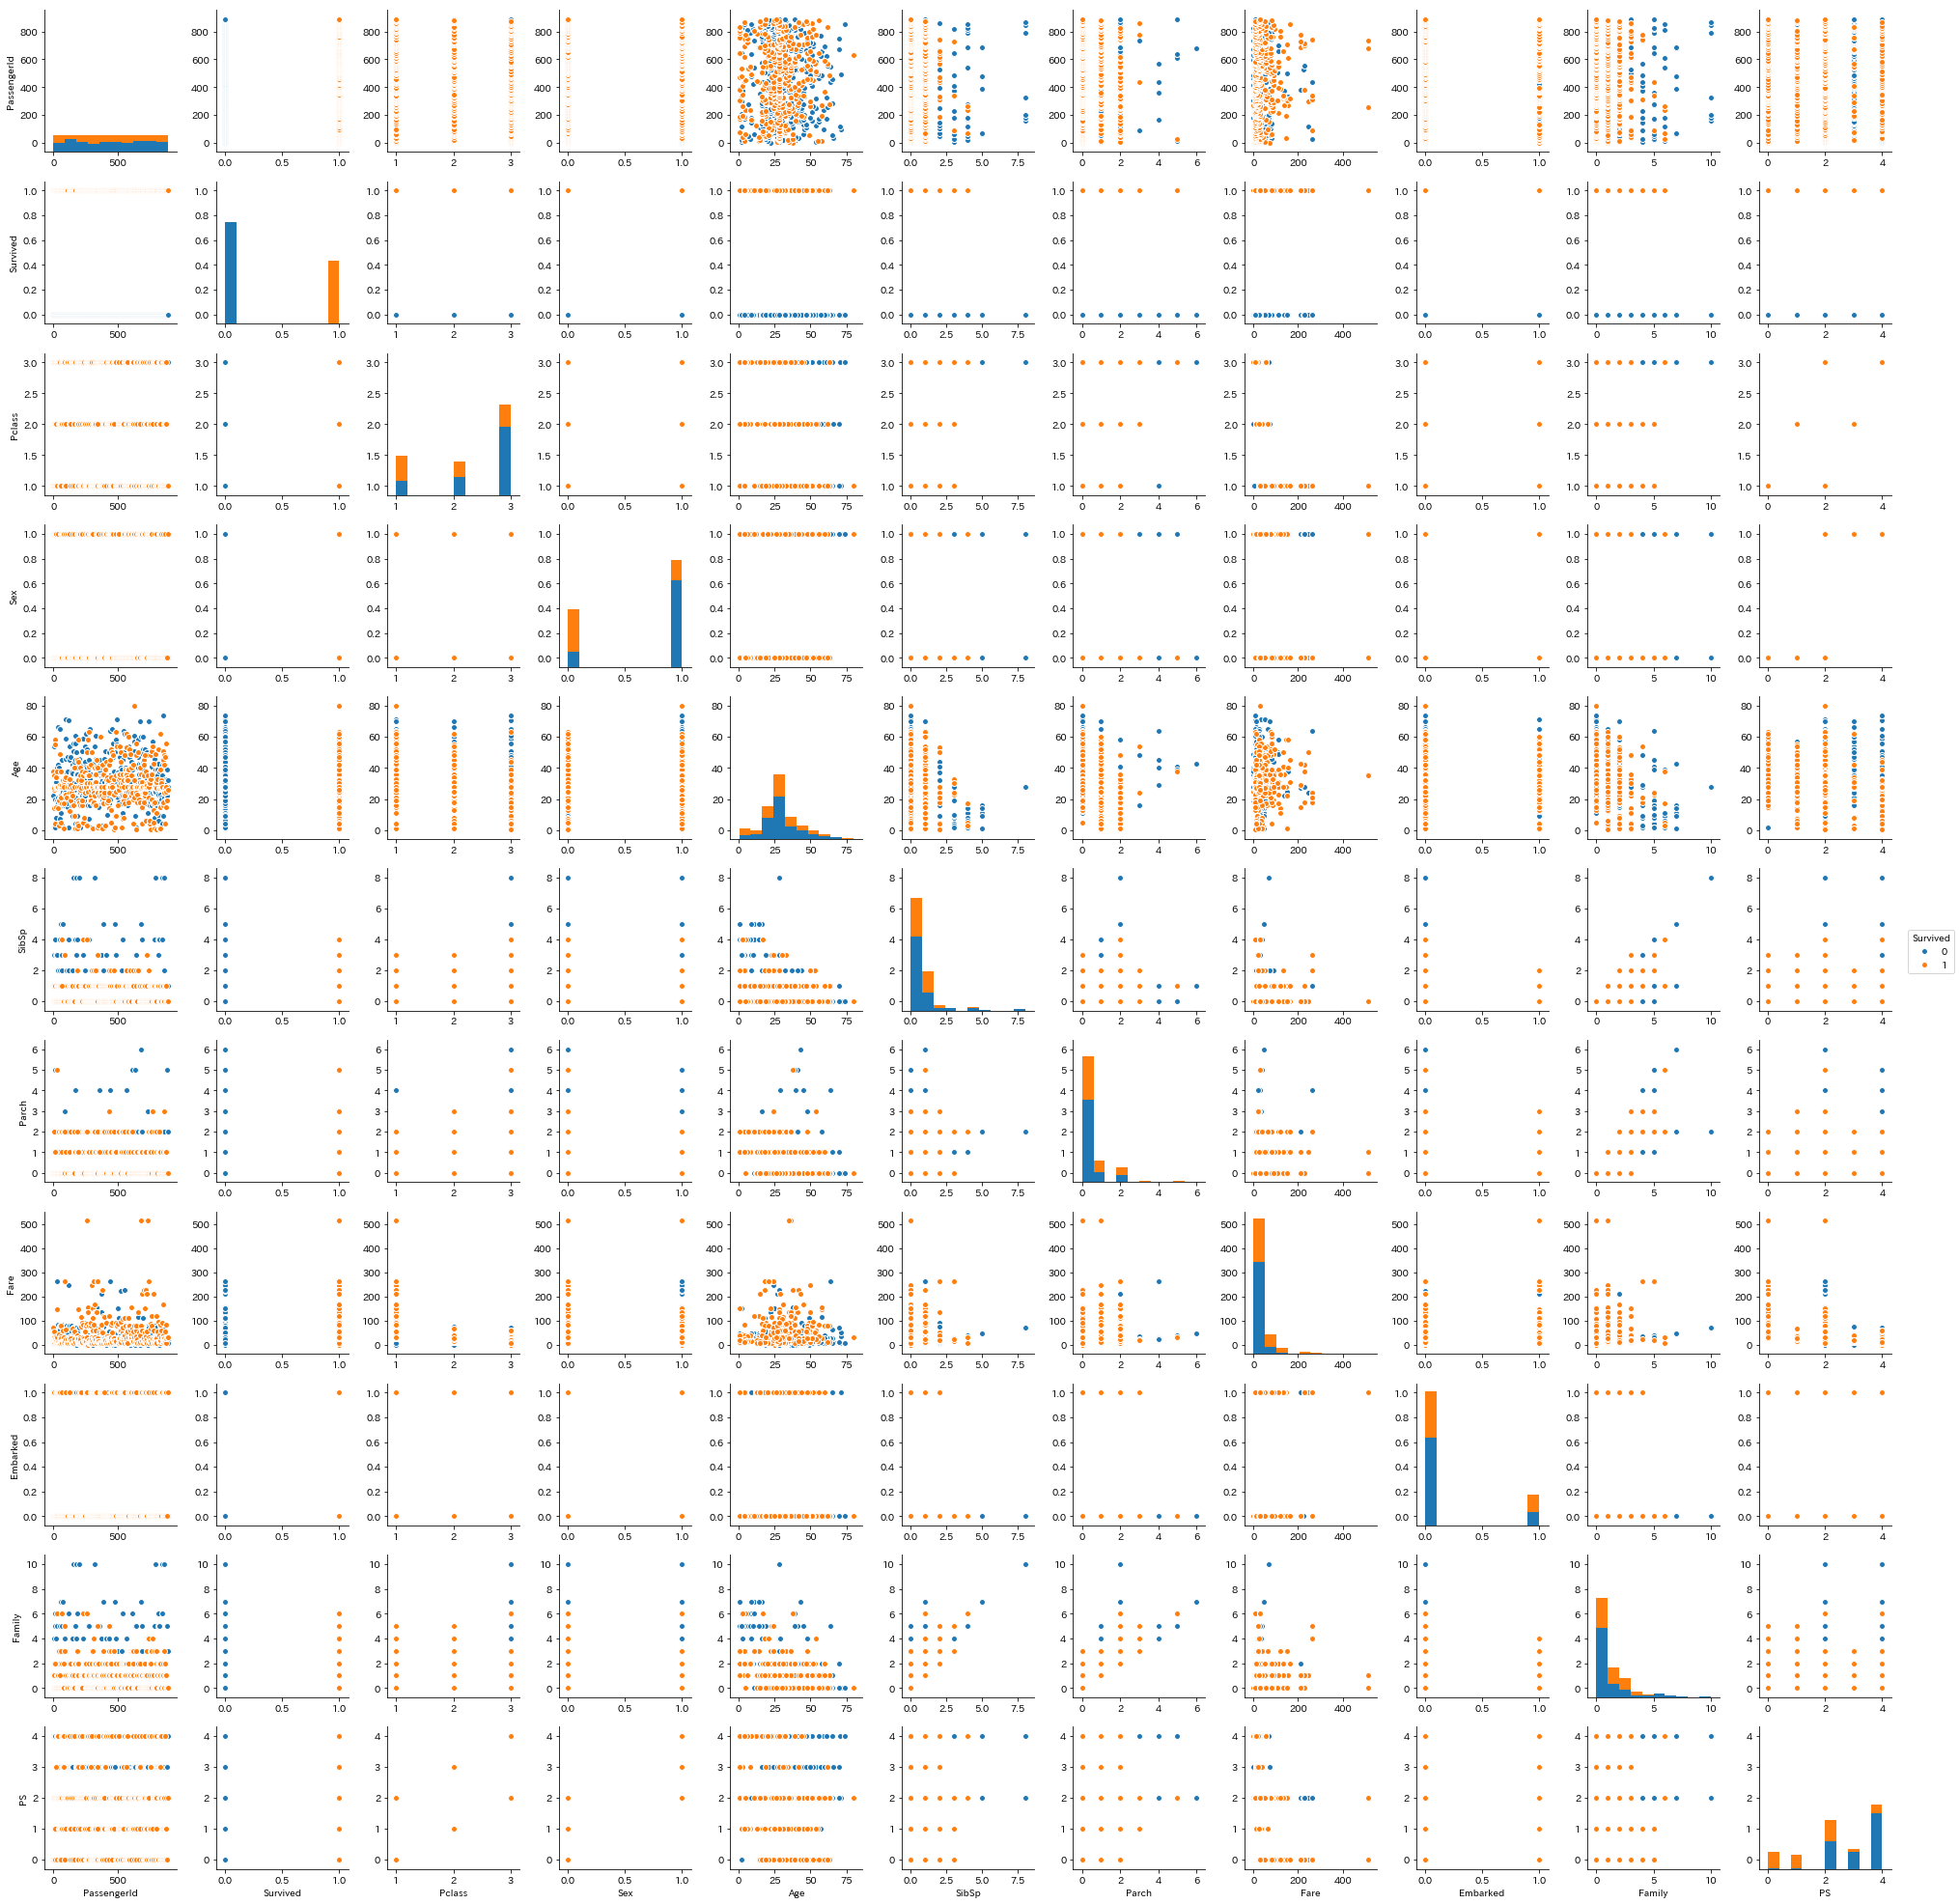

In [98]:
# 0,1データが多いため図にするのはあまり意味がない
sns.pairplot(df_train, hue='Survived')

# モデル作成

In [ ]:
# PassengerId, Age, Fare, PSのみ特徴量にする

In [146]:
train_X = df_train[['PassengerId', 'Age', 'Fare', 'PS']]

In [147]:
train_y = df_train['Survived']

In [148]:
model = RandomForestClassifier(n_estimators=80)

In [149]:
model.fit(train_X, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [150]:
train_X.columns

Index(['PassengerId', 'Age', 'Fare', 'PS'], dtype='object')

In [151]:
# 特徴量毎にランダムフォレストの重要度を確認
for c, m in zip(train_X.columns, model.feature_importances_):
    print(c, m)

PassengerId 0.21723995664702195
Age 0.1858934216958314
Fare 0.23173113992948352
PS 0.3651354817276632


# 予測

In [154]:
test_X = df_test[['PassengerId', 'Age', 'Fare', 'PS']]

In [155]:
pred_y = model.predict(test_X)

In [156]:
pred_y[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=int64)

# 提出ファイル作成

In [157]:
output = pd.read_csv('test.csv')

In [158]:
output['Survived'] = pred_y

In [159]:
output[['PassengerId','Survived']].to_csv('submission_180919_2.csv', index=False)

In [ ]:
# score = 0.75598